In [48]:
# import necessary packages

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
from datetime import datetime as dt
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport
import math
import xarray

In [2]:
# import hurricane data from csv

hurdat = pd.read_csv(r"C:/Users/jacks/Documents/Springboard/hurricanes_capstone/HURDAT2 Data.csv")

In [3]:
hurdat.head()

,Name,Date,Time,Status,Lat,Long,Maximum sustained wind,Minimum Pressure,34 kt radii NE,34 kt radii SE,...,50 kt radii SW,50 kt radii NW,64 kt radii NE,64 kt radii SE,64 kt radii SW,64 kt radii NW,87 kt radii NE (est),87 kt radii SE (est),87 kt radii SW (est),87 kt radii NW (est)
0,Alex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FALSE,20040731,1800,TD,30.3N,78.3W,25.0,1010.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FALSE,20040801,0,TD,31.0N,78.8W,25.0,1009.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FALSE,20040801,600,TD,31.5N,79.0W,25.0,1009.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FALSE,20040801,1200,TD,31.6N,79.1W,30.0,1009.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# fix date column

hurdat['Date'] = pd.to_datetime(hurdat['Date'],errors='coerce',yearfirst=False)

In [5]:
# fix the name column
# remove whitespace and capitalize the first letter of each name

name_col = [name.title() for name in list(hurdat['Name'].str.lstrip())]

# create a list of names called 'new_names'
# make each 'FALSE' the preceeding name until the next name

new_names = []
name = ''

for x in name_col:
    if x != 'False':
        new_names.append(x)
        name = x
    else:
        new_names.append(name)
        
# add Storm Names column

hurdat['Storm_Name'] = new_names

# remove the Name column

hurdat.drop('Name',axis=1,inplace=True)

In [6]:
# remove rows with excessive NaN values
# without doing this I am unable to change the Year datatype

hurdat.dropna(axis=0,thresh=10,inplace=True)

In [7]:
# extract year from date column and create Year column as int datatype

hurdat['Year'] = pd.array([i.year for i in hurdat.Date], dtype='int')

In [8]:
# rearrange the columns

hurdat = hurdat.reindex(columns = ['Year','Storm_Name','Time','Date','Status','Lat','Long','Maximum sustained wind','Minimum Pressure','34 kt radii NE','34 kt radii SE','34 kt radii SW','34 kt radii NW','50 kt radii NE','50 kt radii SE','50 kt radii SW','50 kt radii NW','64 kt radii NE','64 kt radii SE','64 kt radii SW','64 kt radii NW','87 kt radii NE (est)','87 kt radii SE (est)','87 kt radii SW (est)','87 kt radii NW (est)'])

In [9]:
# set Year to index

hurdat = hurdat.set_index(['Year'])

In [10]:
# change column names to names easier to work with

hurdat.columns = ['Storm_Name','Time','Date', 'Status', 'Lat', 'Long', 'Max_Wind',
       'Min_Pressure', 'ne_34_kt', 'se_34_kt',
       'sw_34_kt', 'nw_34_kt', 'ne_50_kt', 'se_50_kt',
       'sw_50_kt', 'nw_50_kt', 'ne_64_kt', 'se_64_kt',
       'sw_64_kt', 'nw_64_kt', 'ne_87_kt', 'se_87_kt',
       'sw_87_kt', 'nw_87_kt']

## Clean each radii and calculate the wind field (diameter) of each wind range

In [11]:
# remove negative values from the radii

hurdat['ne_34_kt'].clip(lower=0, inplace=True)
hurdat['se_34_kt'].clip(lower=0, inplace=True)
hurdat['sw_34_kt'].clip(lower=0, inplace=True)
hurdat['nw_34_kt'].clip(lower=0, inplace=True)
hurdat['ne_50_kt'].clip(lower=0, inplace=True)
hurdat['se_50_kt'].clip(lower=0, inplace=True)
hurdat['sw_50_kt'].clip(lower=0, inplace=True)
hurdat['nw_50_kt'].clip(lower=0, inplace=True)
hurdat['ne_64_kt'].clip(lower=0, inplace=True)
hurdat['se_64_kt'].clip(lower=0, inplace=True)
hurdat['sw_64_kt'].clip(lower=0, inplace=True)
hurdat['nw_64_kt'].clip(lower=0, inplace=True)
hurdat['ne_87_kt'].clip(lower=0, inplace=True)
hurdat['se_87_kt'].clip(lower=0, inplace=True)
hurdat['sw_87_kt'].clip(lower=0, inplace=True)
hurdat['nw_87_kt'].clip(lower=0, inplace=True)

In [12]:
# caluculate effective radius for each wind threshold
# eff_rad_* function calculates the Effective Radius for the 4 wind thresholds
# the value output is in nautical miles

def eff_rad_34(x):
    if x['Max_Wind']>=34:
        num = (0.5*(math.sqrt((x['ne_34_kt']**2) + (x['se_34_kt']**2) + (x['sw_34_kt']**2) + (x['nw_34_kt']**2))))
        return round(num,2)

def eff_rad_50(x):
    if x['Max_Wind']>=50:
        num = (0.5*(math.sqrt((x['ne_50_kt']**2) + (x['se_50_kt']**2) + (x['sw_50_kt']**2) + (x['nw_50_kt']**2))))
        return round(num,2)

def eff_rad_64(x):
    if x['Max_Wind']>=64:
        num = (0.5*(math.sqrt((x['ne_64_kt']**2) + (x['se_64_kt']**2) + (x['sw_64_kt']**2) + (x['nw_64_kt']**2))))
        return round(num,2)
    
def eff_rad_87(x):
    if x['Max_Wind']>=87:
        num = (0.5*(math.sqrt((x['ne_87_kt']**2) + (x['se_87_kt']**2) + (x['sw_87_kt']**2) + (x['nw_87_kt']**2))))
        return round(num,2)

In [13]:
# use .apply function to create new columns

hurdat['34kt Wind Field']=hurdat.apply(eff_rad_34, axis=1)
hurdat['50kt Wind Field']=hurdat.apply(eff_rad_50, axis=1)
hurdat['64kt Wind Field']=hurdat.apply(eff_rad_64, axis=1)
hurdat['87kt Wind Field']=hurdat.apply(eff_rad_87, axis=1)

In [14]:
# change NaN values in eff_rad_* columns to 0.0

hurdat['34kt Wind Field']=hurdat['34kt Wind Field'].fillna(0.0)
hurdat['50kt Wind Field']=hurdat['50kt Wind Field'].fillna(0.0)
hurdat['64kt Wind Field']=hurdat['64kt Wind Field'].fillna(0.0)
hurdat['87kt Wind Field']=hurdat['87kt Wind Field'].fillna(0.0)

In [16]:
# drop the wind radii columns

hsi = hurdat.drop(hurdat.columns[8:24], axis=1)

In [17]:
hsi.head()

,Storm_Name,Time,Date,Status,Lat,Long,Max_Wind,Min_Pressure,34kt Wind Field,50kt Wind Field,64kt Wind Field,87kt Wind Field
Year,,,,,,,,,,,,
2004,Alex,1800,2004-07-31,TD,30.3N,78.3W,25.0,1010.0,0.00,0.0,0.0,0.0
2004,Alex,0,2004-08-01,TD,31.0N,78.8W,25.0,1009.0,0.00,0.0,0.0,0.0
2004,Alex,600,2004-08-01,TD,31.5N,79.0W,25.0,1009.0,0.00,0.0,0.0,0.0
2004,Alex,1200,2004-08-01,TD,31.6N,79.1W,30.0,1009.0,0.00,0.0,0.0,0.0
2004,Alex,1800,2004-08-01,TS,31.6N,79.2W,35.0,1009.0,35.36,0.0,0.0,0.0


In [18]:
# define list of times

times = ['0','600','1200','1800']

# create a list of observations not in 'times' 

off_times = [x for x in hsi['Time'] if x not in times]   

# find the percentage of observations with off_times

(len(off_times)/len(hsi['Time']))*100

2.9043142926006267

In [19]:
# observe data for rows that are in 'off_times'

off_times_df = hsi[hsi['Time'].isin(off_times)]

# find the percentage of observations for err_rad_* in off_times_df are 0 or 999

print(str(off_times_df[off_times_df['34kt Wind Field'].isin([0.00, 999.0])]['34kt Wind Field'].count())+' / '+str(len(off_times)))

((off_times_df[off_times_df['34kt Wind Field'].isin([0.00, 999.0])]['34kt Wind Field'].count())/len(off_times))*100

93 / 241


38.589211618257266

In [20]:
# a large percentage of rows that are not at 0, 600, 1200, or 1800 have erroneous data
# remove those rows whose time is not == 0, 600, 1200, 0r 1800

hsi = hsi[hsi['Time'].isin(['0','600','1200','1800'])]

In [21]:
# strip whitespace in front of statuses

hsi['Status'] = hsi['Status'].str.strip()

# remove storms that aren't a tropical depression, tropical storm, or hurricane

drop_status=['EX','WV','LO','SS','SD','DB']
hsi = hsi[~hsi['Status'].isin(drop_status)]
print(hsi['Status'].unique())

['TD' 'TS' 'HU']


In [22]:
# remove the N and W from the lat and long

hsi['Lat'] = hsi['Lat'].str.strip(to_strip='N')
hsi['Long'] = hsi['Long'].str.strip(to_strip='W')

In [23]:
# change the lat and long to numeric data

hsi['Lat'] = hsi['Lat'].astype('float64')
hsi['Long'] = hsi['Long'].astype('float64')

In [24]:
# convert Long coordinates to 360 degree scale

hsi['Long'] = 359-hsi['Long']

In [25]:
hsi.head()

,Storm_Name,Time,Date,Status,Lat,Long,Max_Wind,Min_Pressure,34kt Wind Field,50kt Wind Field,64kt Wind Field,87kt Wind Field
Year,,,,,,,,,,,,
2004,Alex,1800,2004-07-31,TD,30.3,280.7,25.0,1010.0,0.00,0.0,0.0,0.0
2004,Alex,0,2004-08-01,TD,31.0,280.2,25.0,1009.0,0.00,0.0,0.0,0.0
2004,Alex,600,2004-08-01,TD,31.5,280.0,25.0,1009.0,0.00,0.0,0.0,0.0
2004,Alex,1200,2004-08-01,TD,31.6,279.9,30.0,1009.0,0.00,0.0,0.0,0.0
2004,Alex,1800,2004-08-01,TS,31.6,279.8,35.0,1009.0,35.36,0.0,0.0,0.0


In [26]:
# define a function to assign intensity points

def intensity(df):
    if df['Max_Wind']<30:
        return 0
    elif df['Max_Wind']>=30 and df['Max_Wind']<=150:
        return round((df['Max_Wind']/30)**2,2)
    else:
        return 25

In [27]:
# create intensity list to insert 

intensity = list(hsi.apply(intensity, axis=1))

# insert the intensity list as Intensity_pts column

hsi.insert(8, 'Intensity_pts', intensity, True)

In [28]:
hsi.describe()

,Lat,Long,Max_Wind,Min_Pressure,Intensity_pts,34kt Wind Field,50kt Wind Field,64kt Wind Field,87kt Wind Field
count,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000
mean,24.253810,296.762170,55.678043,990.046407,4.185542,75.297347,26.045479,9.945107,2.764592
std,8.265535,19.813557,26.473478,20.504170,4.346416,61.119528,33.483274,18.254421,7.988081
min,7.700000,254.000000,15.000000,882.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.125000,280.700000,35.000000,982.000000,1.360000,31.820000,0.000000,0.000000,0.000000
50%,23.900000,295.900000,50.000000,997.000000,2.780000,66.330000,10.610000,0.000000,0.000000
75%,30.700000,312.700000,70.000000,1005.000000,5.440000,111.360000,45.280000,15.000000,0.000000
max,48.800000,353.000000,160.000000,1017.000000,25.000000,415.090000,196.530000,117.150000,48.870000


In order to be able to calculate the hurricane severity we must first have winds >= 30kts to register on the Intensity 25 point scale

This means we can drop the observations with winds below 30kts

In [29]:
# drop all observations with a max wind < 30kts

hsi = hsi.loc[hsi['Max_Wind']>=30]

In [30]:
hsi.describe()

,Lat,Long,Max_Wind,Min_Pressure,Intensity_pts,34kt Wind Field,50kt Wind Field,64kt Wind Field,87kt Wind Field
count,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000
mean,24.196359,297.307015,57.446626,989.111132,4.418515,79.488507,27.495208,10.498666,2.918473
std,8.225277,19.484104,26.080182,20.641486,4.348960,60.086209,33.818294,18.600064,8.180016
min,7.700000,257.100000,30.000000,882.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17.200000,281.800000,35.000000,980.000000,1.360000,37.750000,0.000000,0.000000,0.000000
50%,23.800000,296.400000,50.000000,996.000000,2.780000,70.710000,15.000000,0.000000,0.000000
75%,30.500000,312.700000,70.000000,1005.000000,5.440000,114.020000,47.430000,17.320000,0.000000
max,48.800000,353.000000,160.000000,1015.000000,25.000000,415.090000,196.530000,117.150000,48.870000


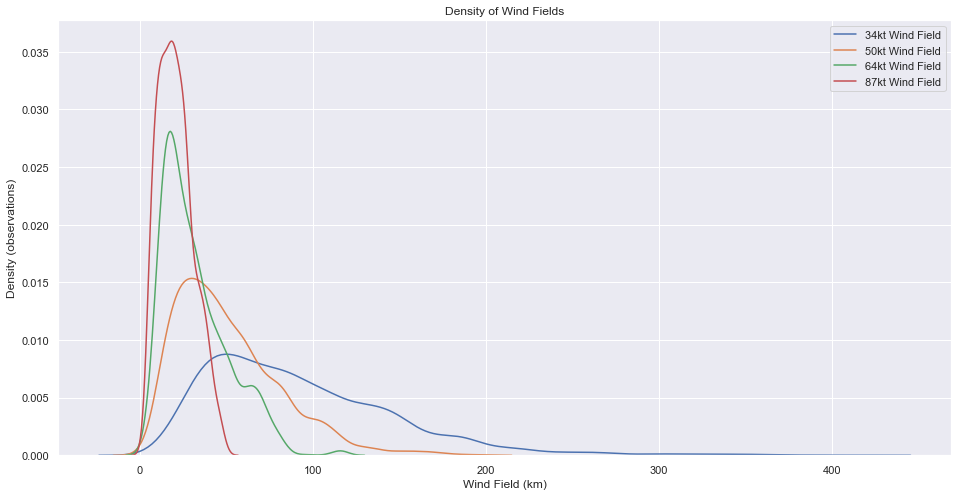

In [34]:
# using series created from each wind field with winds over 0 kt
# produce a kde plot to see the density of observations

plt.figure(figsize=(16,8))
sns.kdeplot(data=hsi[hsi['34kt Wind Field']>0]['34kt Wind Field'], label='34kt Wind Field')
sns.kdeplot(data=hsi[hsi['50kt Wind Field']>0]['50kt Wind Field'], label='50kt Wind Field')
sns.kdeplot(data=hsi[hsi['64kt Wind Field']>0]['64kt Wind Field'], label='64kt Wind Field')
sns.kdeplot(data=hsi[hsi['87kt Wind Field']>0]['87kt Wind Field'], label='87kt Wind Field')

plt.xlabel('Wind Field (km)')
plt.ylabel('Density (observations)')
plt.title('Density of Wind Fields')
plt.legend()

plt.show()

The range of values for 34kt effective radius is 7.07 - 415.09 and the range for intesity points for 34kt radius is 0-3. Therefore 0:7.07 and 3:408.02. Subtract 7.07 from each ratio and 0:0 and 3:408.02

To find the size points for observations of 34kt effective radius take the effective radius value, multiply it by 3, and divide by 408.02

The same calculations were performed on each respective effective radius

In [35]:
# define a function to calculate size points

def size_pts(df):
    if df['34kt Wind Field']>0:
        pts_34 = 3*df['34kt Wind Field']/408.02
        if df['50kt Wind Field']>0:
            pts_50 = 4*df['50kt Wind Field']/192.99
            if df['64kt Wind Field']>0:
                pts_64 = 8*df['64kt Wind Field']/112.15
                if df['87kt Wind Field']>0:
                    pts_87 = 10*df['87kt Wind Field']/45.2
                    return pts_34+pts_50+pts_64+pts_87     

In [36]:
# insert the Size_pts column based on the results from the size_pts function

hsi.insert(9,'Size_pts', list(hsi.apply(size_pts, axis=1)), True)

In [37]:
# replace NaN values with 0

hsi['Size_pts'].fillna(value=0, inplace=True)

In [39]:
# create Severity column by adding Intensity pts and Size pts

hsi.insert(10, 'Severity', hsi['Intensity_pts']+hsi['Size_pts'], True)

In [40]:
hsi.head()

,Storm_Name,Time,Date,Status,Lat,Long,Max_Wind,Min_Pressure,Intensity_pts,Size_pts,Severity,34kt Wind Field,50kt Wind Field,64kt Wind Field,87kt Wind Field
Year,,,,,,,,,,,,,,,
2004,Alex,1200,2004-08-01,TD,31.6,279.9,30.0,1009.0,1.00,0.0,1.00,0.00,0.00,0.0,0.0
2004,Alex,1800,2004-08-01,TS,31.6,279.8,35.0,1009.0,1.36,0.0,1.36,35.36,0.00,0.0,0.0
2004,Alex,0,2004-08-02,TS,31.5,279.7,35.0,1007.0,1.36,0.0,1.36,35.36,0.00,0.0,0.0
2004,Alex,600,2004-08-02,TS,31.4,279.6,40.0,1005.0,1.78,0.0,1.78,70.36,0.00,0.0,0.0
2004,Alex,1200,2004-08-02,TS,31.3,280.0,50.0,992.0,2.78,0.0,2.78,66.57,21.21,0.0,0.0


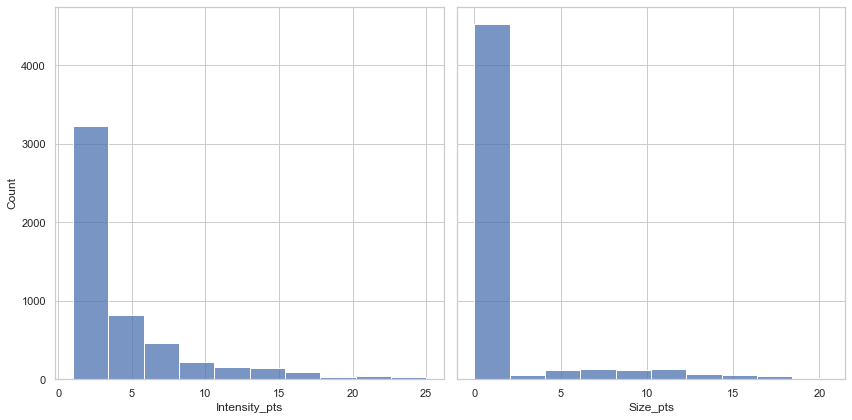

In [52]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,6))

sns.histplot(ax=axes[0], data=hsi, x='Intensity_pts', bins=10)
sns.histplot(ax=axes[1], data=hsi, x='Size_pts', bins=10)

plt.tight_layout()
plt.show()

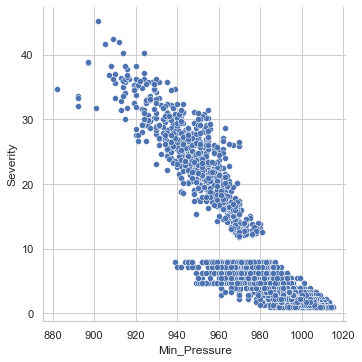

In [53]:
sns.relplot(data=hsi, x='Min_Pressure', y='Severity')
plt.show()

need to investigate why there's a gap around 10

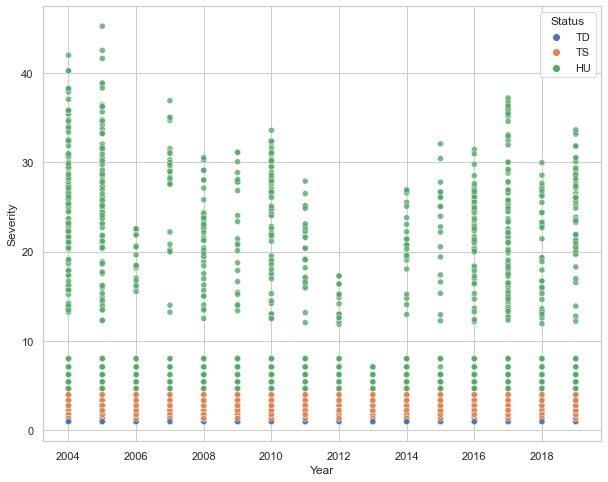

In [56]:
plt.figure(figsize = (10,8))
sns.scatterplot(data=hsi, x=hsi.index, y='Severity', hue='Status', alpha=0.8)

plt.show()

In [60]:
# find the average severity score for each year

avg_sev = []

for i in hsi.index.unique():
    avg = hsi['Severity'][hsi.index==i].mean()
    avg_sev.append(avg)
    #print(i, avg)

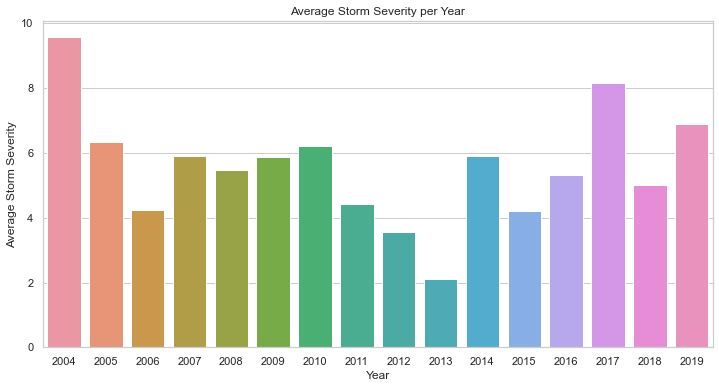

In [58]:
fig = plt.figure()
fig.set_size_inches(12,6)

sns.barplot(x=hsi.index.unique(), y=avg_sev)
plt.title('Average Storm Severity per Year')
plt.ylabel('Average Storm Severity')

plt.show()

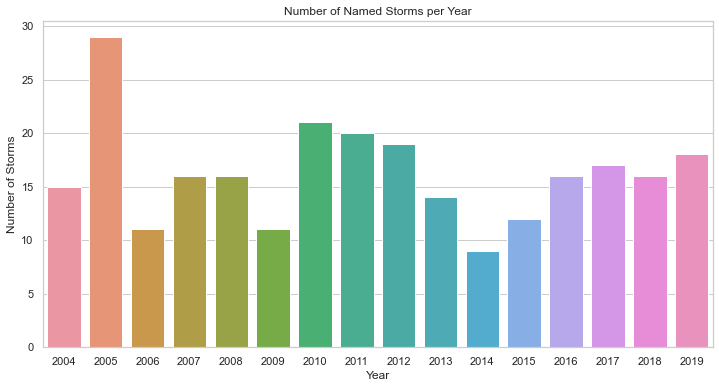

In [59]:
# find the number of storms each year

annual_storms = hsi.groupby([hsi.index])['Storm_Name'].nunique().to_frame('Number of Storms')

fig = plt.figure()
fig.set_size_inches(12,6)
sns.barplot(data=annual_storms, x=annual_storms.index, y='Number of Storms')
plt.title('Number of Named Storms per Year')
plt.ylabel('Number of Storms')
plt.show()

In [62]:
annual_storms

In [ ]:
hsi.head()

In [63]:
# find the minimum pressure, max intensity, max size, and max severity for each storm

min_pressure = hsi.reset_index().groupby(by=[hsi.index, 'Storm_Name'])['Min_Pressure'].min().to_frame()
max_severity = hsi.reset_index().groupby(by=[hsi.index, 'Storm_Name'])['Severity'].max().to_frame()
max_intensity = hsi.reset_index().groupby(by=[hsi.index, 'Storm_Name'])['Intensity_pts'].max().to_frame()
max_size = hsi.reset_index().groupby(by=[hsi.index, 'Storm_Name'])['Size_pts'].max().to_frame()
max_wind = hsi.reset_index().groupby(by=[hsi.index, 'Storm_Name'])['Max_Wind'].max().to_frame()

In [64]:
hsi2 = min_pressure.merge(
    max_severity.merge(
        max_intensity.merge(
            max_size.merge(
                max_wind, on=['Year','Storm_Name']), on=['Year','Storm_Name']), on=['Year','Storm_Name']), on=['Year','Storm_Name'])

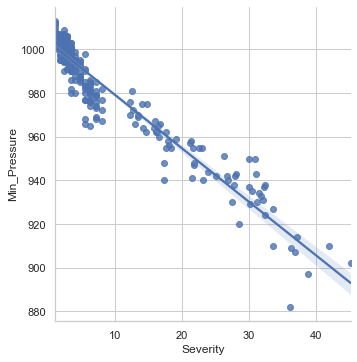

In [65]:
sns.lmplot(data=hsi2, y='Min_Pressure', x='Severity')
plt.show()

In [67]:
hsi2.head()

Min_Pressure   Severity  Intensity_pts  Size_pts  Max_Wind
Year Storm_Name                                                            
2004 Alex               957.0  21.197778          12.25  9.296774     105.0
     Bonnie            1001.0   3.360000           3.36  0.000000      55.0
     Charley            947.0  21.719795          17.36  5.179974     125.0
     Danielle           964.0  15.793862          10.03  5.763862      95.0
     Earl              1009.0   2.250000           2.25  0.000000      45.0

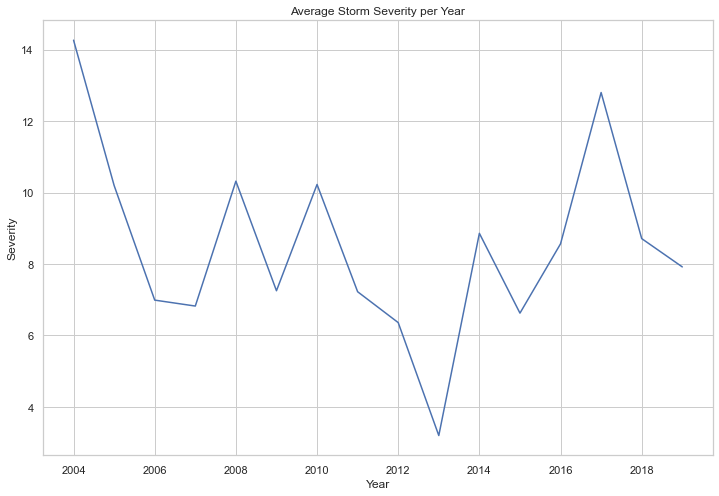

In [68]:
plt.figure(figsize=(12,8))
sns.lineplot(data=hsi2, x='Year', y='Severity', ci=None)
plt.title('Average Storm Severity per Year')
plt.show()

In [69]:
hsi2.groupby(['Year'])['Severity'].mean()

Year
2004    14.262848
2005    10.194991
2006     6.988386
2007     6.822134
2008    10.317261
2009     7.250705
2010    10.224843
2011     7.222874
2012     6.359229
2013     3.198571
2014     8.857659
2015     6.624079
2016     8.564134
2017    12.798238
2018     8.709826
2019     7.917968
Name: Severity, dtype: float64

In [ ]:
sns.pairplot(hsi2, kind='reg', markers='.')
plt.show()

In [70]:
# define a function to categorize each storm

def storm_categorizer(storm):
    if storm['Max_Wind']<=33:
        return 'Tropical Depression'
    elif (storm['Max_Wind']>33) and (storm['Max_Wind']<=63):
        return 'Tropical Storm'
    elif (storm['Max_Wind']>63) and (storm['Max_Wind']<=82):
        return 'Cat 1: Hurricane'
    elif (storm['Max_Wind']>82) and (storm['Max_Wind']<=95):
        return 'Cat 2: Hurricane'
    elif (storm['Max_Wind']>95) and (storm['Max_Wind']<=112):
        return 'Cat 3: Hurricane'
    elif (storm['Max_Wind']>112) and (storm['Max_Wind']<=136):
        return 'Cat 4: Hurricane'
    elif storm['Max_Wind']>136:
        return 'Cat 5: Hurricane'

In [71]:
hsi2['Category'] = hsi2.apply(storm_categorizer, axis=1)

In [72]:
hsi2.head()

Min_Pressure   Severity  Intensity_pts  Size_pts  Max_Wind  \
Year Storm_Name                                                               
2004 Alex               957.0  21.197778          12.25  9.296774     105.0   
     Bonnie            1001.0   3.360000           3.36  0.000000      55.0   
     Charley            947.0  21.719795          17.36  5.179974     125.0   
     Danielle           964.0  15.793862          10.03  5.763862      95.0   
     Earl              1009.0   2.250000           2.25  0.000000      45.0   

                         Category  
Year Storm_Name                    
2004 Alex        Cat 3: Hurricane  
     Bonnie        Tropical Storm  
     Charley     Cat 4: Hurricane  
     Danielle    Cat 2: Hurricane  
     Earl          Tropical Storm

# Using k-Nearest Neighbors to predict storm category

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts

In [75]:
# due to multicollinearity I've decided to use only Min_Pressure and Size_pts

features = hsi2.drop(['Category','Severity','Intensity_pts','Max_Wind'], axis=1)
target = hsi2['Category']

In [76]:
knn = KNeighborsClassifier(n_neighbors=5)

In [77]:
X_train, X_test, y_train, y_test = tts(features, target)

In [78]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [79]:
y_pred = knn.predict(X_test)

In [80]:
print(y_pred)

['Tropical Storm' 'Tropical Storm' 'Cat 5: Hurricane' 'Cat 1: Hurricane'
 'Cat 1: Hurricane' 'Tropical Storm' 'Cat 1: Hurricane'
 'Tropical Depression' 'Tropical Storm' 'Cat 4: Hurricane'
 'Cat 3: Hurricane' 'Cat 4: Hurricane' 'Tropical Storm' 'Cat 1: Hurricane'
 'Tropical Storm' 'Cat 1: Hurricane' 'Cat 2: Hurricane' 'Tropical Storm'
 'Cat 1: Hurricane' 'Tropical Storm' 'Tropical Storm' 'Tropical Storm'
 'Cat 1: Hurricane' 'Tropical Storm' 'Tropical Storm' 'Cat 1: Hurricane'
 'Tropical Storm' 'Tropical Storm' 'Cat 5: Hurricane' 'Cat 1: Hurricane'
 'Tropical Storm' 'Tropical Storm' 'Cat 4: Hurricane' 'Tropical Storm'
 'Cat 1: Hurricane' 'Cat 1: Hurricane' 'Cat 4: Hurricane'
 'Cat 1: Hurricane' 'Tropical Depression' 'Tropical Storm'
 'Tropical Storm' 'Cat 1: Hurricane' 'Tropical Storm' 'Tropical Storm'
 'Tropical Storm' 'Tropical Storm' 'Tropical Storm' 'Tropical Storm'
 'Cat 5: Hurricane' 'Tropical Storm' 'Cat 4: Hurricane' 'Cat 1: Hurricane'
 'Cat 1: Hurricane' 'Tropical Storm' 'Tropic

In [81]:
knn.score(X_test, y_test)

0.7538461538461538

In [82]:
neighbors = np.arange(1,9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

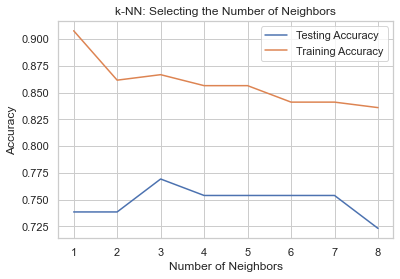

In [83]:
plt.title('k-NN: Selecting the Number of Neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [84]:
knn = KNeighborsClassifier(n_neighbors=3)

In [85]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [86]:
y_pred = knn.predict(X_test)

In [87]:
print(y_pred)

['Tropical Storm' 'Tropical Storm' 'Cat 5: Hurricane' 'Cat 1: Hurricane'
 'Cat 1: Hurricane' 'Tropical Storm' 'Cat 1: Hurricane'
 'Tropical Depression' 'Tropical Storm' 'Cat 4: Hurricane'
 'Cat 3: Hurricane' 'Cat 4: Hurricane' 'Cat 1: Hurricane'
 'Cat 1: Hurricane' 'Tropical Storm' 'Cat 1: Hurricane' 'Cat 2: Hurricane'
 'Tropical Storm' 'Cat 1: Hurricane' 'Tropical Storm' 'Tropical Storm'
 'Tropical Storm' 'Cat 1: Hurricane' 'Tropical Storm' 'Tropical Storm'
 'Cat 1: Hurricane' 'Tropical Storm' 'Tropical Storm' 'Cat 5: Hurricane'
 'Cat 1: Hurricane' 'Tropical Storm' 'Tropical Storm' 'Cat 4: Hurricane'
 'Tropical Storm' 'Cat 1: Hurricane' 'Cat 1: Hurricane' 'Cat 4: Hurricane'
 'Cat 1: Hurricane' 'Tropical Depression' 'Tropical Storm'
 'Tropical Storm' 'Cat 1: Hurricane' 'Tropical Storm' 'Tropical Storm'
 'Tropical Storm' 'Tropical Storm' 'Tropical Storm' 'Tropical Storm'
 'Cat 5: Hurricane' 'Tropical Storm' 'Cat 4: Hurricane' 'Cat 1: Hurricane'
 'Cat 1: Hurricane' 'Tropical Storm' 'Trop

In [88]:
knn.score(X_test, y_test)

0.7692307692307693

# Find another method for modeling

In [ ]:
dummy = pd.get_dummies(hsi2['Category'])

In [ ]:
hsi3 = pd.concat([hsi2, dummy], axis=1)
hsi3.head()

# Using Clustering to predict storm category

In [ ]:
from sklearn.cluster import KMeans